In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from easymore import Easymore
import numpy as np
import rasterio
from rasterio.plot import show
import netCDF4

In [6]:
#Variables of the gpkg/shp file to find the ID that EASYMORE requires

# Load the GeoPackage (GPKG) file
gpkg_file_path = 'proj/snow_proj/basins/hydrofabrics/USCATB_hydrofabric_reprojected.shp'
gpkg_data = gpd.read_file(gpkg_file_path) 

# Extract latitude and longitude coordinates from the geometry column
gpkg_data['latitude'] = gpkg_data.geometry.centroid.y
gpkg_data['longitude'] = gpkg_data.geometry.centroid.x

# Drop the geometry column as it's no longer needed
gpkg_data.drop(columns=['geometry'], inplace=True)

# Print the updated DataFrame information
print("Updated columns in GeoPackage (GPKG) file:")
print(gpkg_data.info())

# Optionally, you can print the first few rows of the updated DataFrame
print("\nSample data with latitude and longitude columns:")
print(gpkg_data.head())


Updated columns in GeoPackage (GPKG) file:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   divide_id   213 non-null    object 
 1   toid        213 non-null    object 
 2   type        213 non-null    object 
 3   ds_id       213 non-null    float64
 4   areasqkm    213 non-null    float64
 5   id          213 non-null    int64  
 6   lengthkm    213 non-null    float64
 7   tot_draina  213 non-null    float64
 8   has_flowli  213 non-null    int64  
 9   geom_Lengt  213 non-null    float64
 10  geom_Area   213 non-null    float64
 11  latitude    213 non-null    float64
 12  longitude   213 non-null    float64
dtypes: float64(8), int64(2), object(3)
memory usage: 21.8+ KB
None

Sample data with latitude and longitude columns:
     divide_id         toid     type  ds_id  areasqkm       id  lengthkm  \
0  cat-2877189  nex-2877190  networ

/tmp/ipykernel_178881/3475274010.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpkg_data['latitude'] = gpkg_data.geometry.centroid.y
/tmp/ipykernel_178881/3475274010.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gpkg_data['longitude'] = gpkg_data.geometry.centroid.x


In [6]:
## Code to fix shpfile subcatchment ids if necessary
import geopandas as gpd
import numpy as np

# Load the reprojected shapefile
shapefile_path = 'proj/snow_proj/basins/hydrofabrics/USCATB_hydrofabric_reprojected.shp'
shapefile = gpd.read_file(shapefile_path)

# Inspect the ID field before cleaning
print("ID field before cleaning:")
print(shapefile['id'].head())

# Function to extract numeric part from the ID
def extract_numeric_id(id_value):
    try:
        # Extract numeric part from the ID
        return int(''.join(filter(str.isdigit, id_value)))
    except ValueError:
        return None

# Apply the function to the 'id' field
shapefile['id'] = shapefile['id'].apply(extract_numeric_id)

# Print the ID field after conversion
print("ID field after conversion to integer:")
print(shapefile['id'].head())

# Check if there are any None values
none_values = shapefile['id'].isnull().sum()
print(f"Number of None values: {none_values}")

# Remove rows with None values if any
shapefile = shapefile.dropna(subset=['id'])

# Ensure 'id' is of integer type
shapefile['id'] = shapefile['id'].astype(int)

# Print total bounds to debug the aspect ratio error
print("Total bounds of the shapefile:")
print(shapefile.total_bounds)

# Save the shapefile with the cleaned ID field
shapefile.to_file(shapefile_path)

print("Cleaned shapefile saved successfully.")

ID field before cleaning:
0    wb-2877189
1    wb-2877479
2    wb-2877457
3    wb-2877573
4    wb-2877773
Name: id, dtype: object
ID field after conversion to integer:
0    2877189
1    2877479
2    2877457
3    2877573
4    2877773
Name: id, dtype: int64
Number of None values: 0
Total bounds of the shapefile:
[-119.79983917   37.73939913 -119.19926271   38.18644573]
Cleaned shapefile saved successfully.


In [ ]:
#Proceeding with EASYMORE remapping tool

# loading EASYMORE
#from easymore import easymore # for version 1 and below
from easymore import Easymore # for version 2 and above

# initializing EASYMORE object
# esmr = easymore() # for version 1 and below
esmr = Easymore() # for version 2 and above

# specifying EASYMORE objects
# name of the case; the temporary, remapping and remapped file names include case name
esmr.case_name                = 'USCATB_20150305_ASO'   ###           
# temporary path that the EASYMORE generated GIS files and remapped file will be saved
esmr.temp_dir                 = './temporary/'
# name of target shapefile that the source netcdf files should be remapped to
esmr.target_shp               = 'proj/snow_proj/basins/hydrofabrics/USCATB_hydrofabric_reprojected.shp' ###
esmr.target_shp_ID            = 'id' # if not provided easymore give ID according to shape order in shapefile
# name of netCDF file(s); multiple files can be specified with *
esmr.source_nc                = 'proj/snow_proj/basins/ASO_basins/CA/reprojected/ASO_50M_SWE_USCATB_20150305_reproj.nc' ###
# name of variables from source netCDF file(s) to be remapped
esmr.var_names                = ['SWE']
# rename the variables from source netCDF file(s) in the remapped files;
# it will be the same as source if not provided
esmr.var_names_remapped       = ['SWE']
# name of variable longitude in source netCDF files
esmr.var_lon                  = 'lon'
# name of variable latitude in source netCDF files
esmr.var_lat                  = 'lat'
# name of variable time in source netCDF file; should be always time
esmr.var_time                 = 'time'
# location where the remapped netCDF file will be saved
esmr.output_dir               = 'proj/snow_proj/basins/remapped_basins/'
# format of the variables to be saved in remapped files,
# if one format provided it will be expanded to other variables
esmr.format_list              = ['f4']
# fill values of the variables to be saved in remapped files,
# if one value provided it will be expanded to other variables
esmr.fill_value_list          = ['-9999.00']
# if required that the remapped values to be saved as csv as well
esmr.save_csv                 = True
esmr.complevel                = 9
# if uncommented EASYMORE will use this and skip GIS tasks, attributes are only to be checked with remapped so can be assured
#esmr.remap_nc                = esmr.temp_dir+esmr.case_name +'_remapping.nc'
#esmr.attr_nc                 = esmr.temp_dir+esmr.case_name +'_attributes.nc'

# execute EASYMORE
esmr.nc_remapper()

EASYMORE version 2.0.0 is initiated.
no author name is provided.
EASYMORE will remap variable  SWE  from source file to variable  SWE  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dimensions of the variables and latitude and longitude
EASYMORE detects that all the variables have dimensions of:
['time', 'lat', 'lon']
EASYMORE detects that the longitude variables has dimensions of:
['lon']
EASYMORE detects that the latitude variables has dimensions of:
['lat']
--CREATING-REMAPPING-FILE--
Started at date and time 2024-06-14 10:12:10.685339
EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that the field for ID is provided in sink/target shapefile
EASYMORE detects that either of the fields for latitude or longitude is not provided in sink/target shapefile
calculating centroid of shapes in WGS84 projection;
for better appximation use the easymore equal area centroid function to preprocess target shapefile
EAS

/home/m10921520/.conda/envs/easymore-env/lib/python3.9/site-packages/easymore/remapper.py:521: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files
/home/m10921520/.conda/envs/easymore-env/lib/python3.9/site-packages/easymore/remapper.py:558: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  attr = attr.drop('index')


EASYMORE version 2.0.0 is initiated.
EASYMORE detects case 1 - regular lat/lon


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

the closest time step to what is provided for vizualization  2015-02-17 00:00:00  is  2015-02-17 00:00:00  with step in the netcdf file:  0
min: 0.0, max: 0.9750376343727112 for variable: SWE in source nc file for the time step: 2015-02-17 00:00:00


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

EASYMORE detects case 1 - regular lat/lon
the closest time step to what is provided for vizualization  2015-02-17 00:00:00  is  2015-02-17 00:00:00  with step in the netcdf file:  0
min: 0.0, max: 0.9750376343727112 for variable: SWE in source nc file for the time step: 2015-02-17 00:00:00
min: 0.0, max: 0.2411586344242096 for variable: SWE in remapped nc file for the time step: 2015-02-17 00:00:00


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

EASYMORE detects case 1 - regular lat/lon
the closest time step to what is provided for vizualization  2015-02-17 00:00:00  is  2015-02-17 00:00:00  with step in the netcdf file:  0
min: 0.0, max: 0.9750376343727112 for variable: SWE in source nc file for the time step: 2015-02-17 00:00:00
min: 0.0, max: 0.2411586344242096 for variable: SWE in remapped nc file for the time step: 2015-02-17 00:00:00


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

NameError: name 'image_list_cropped' is not defined

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

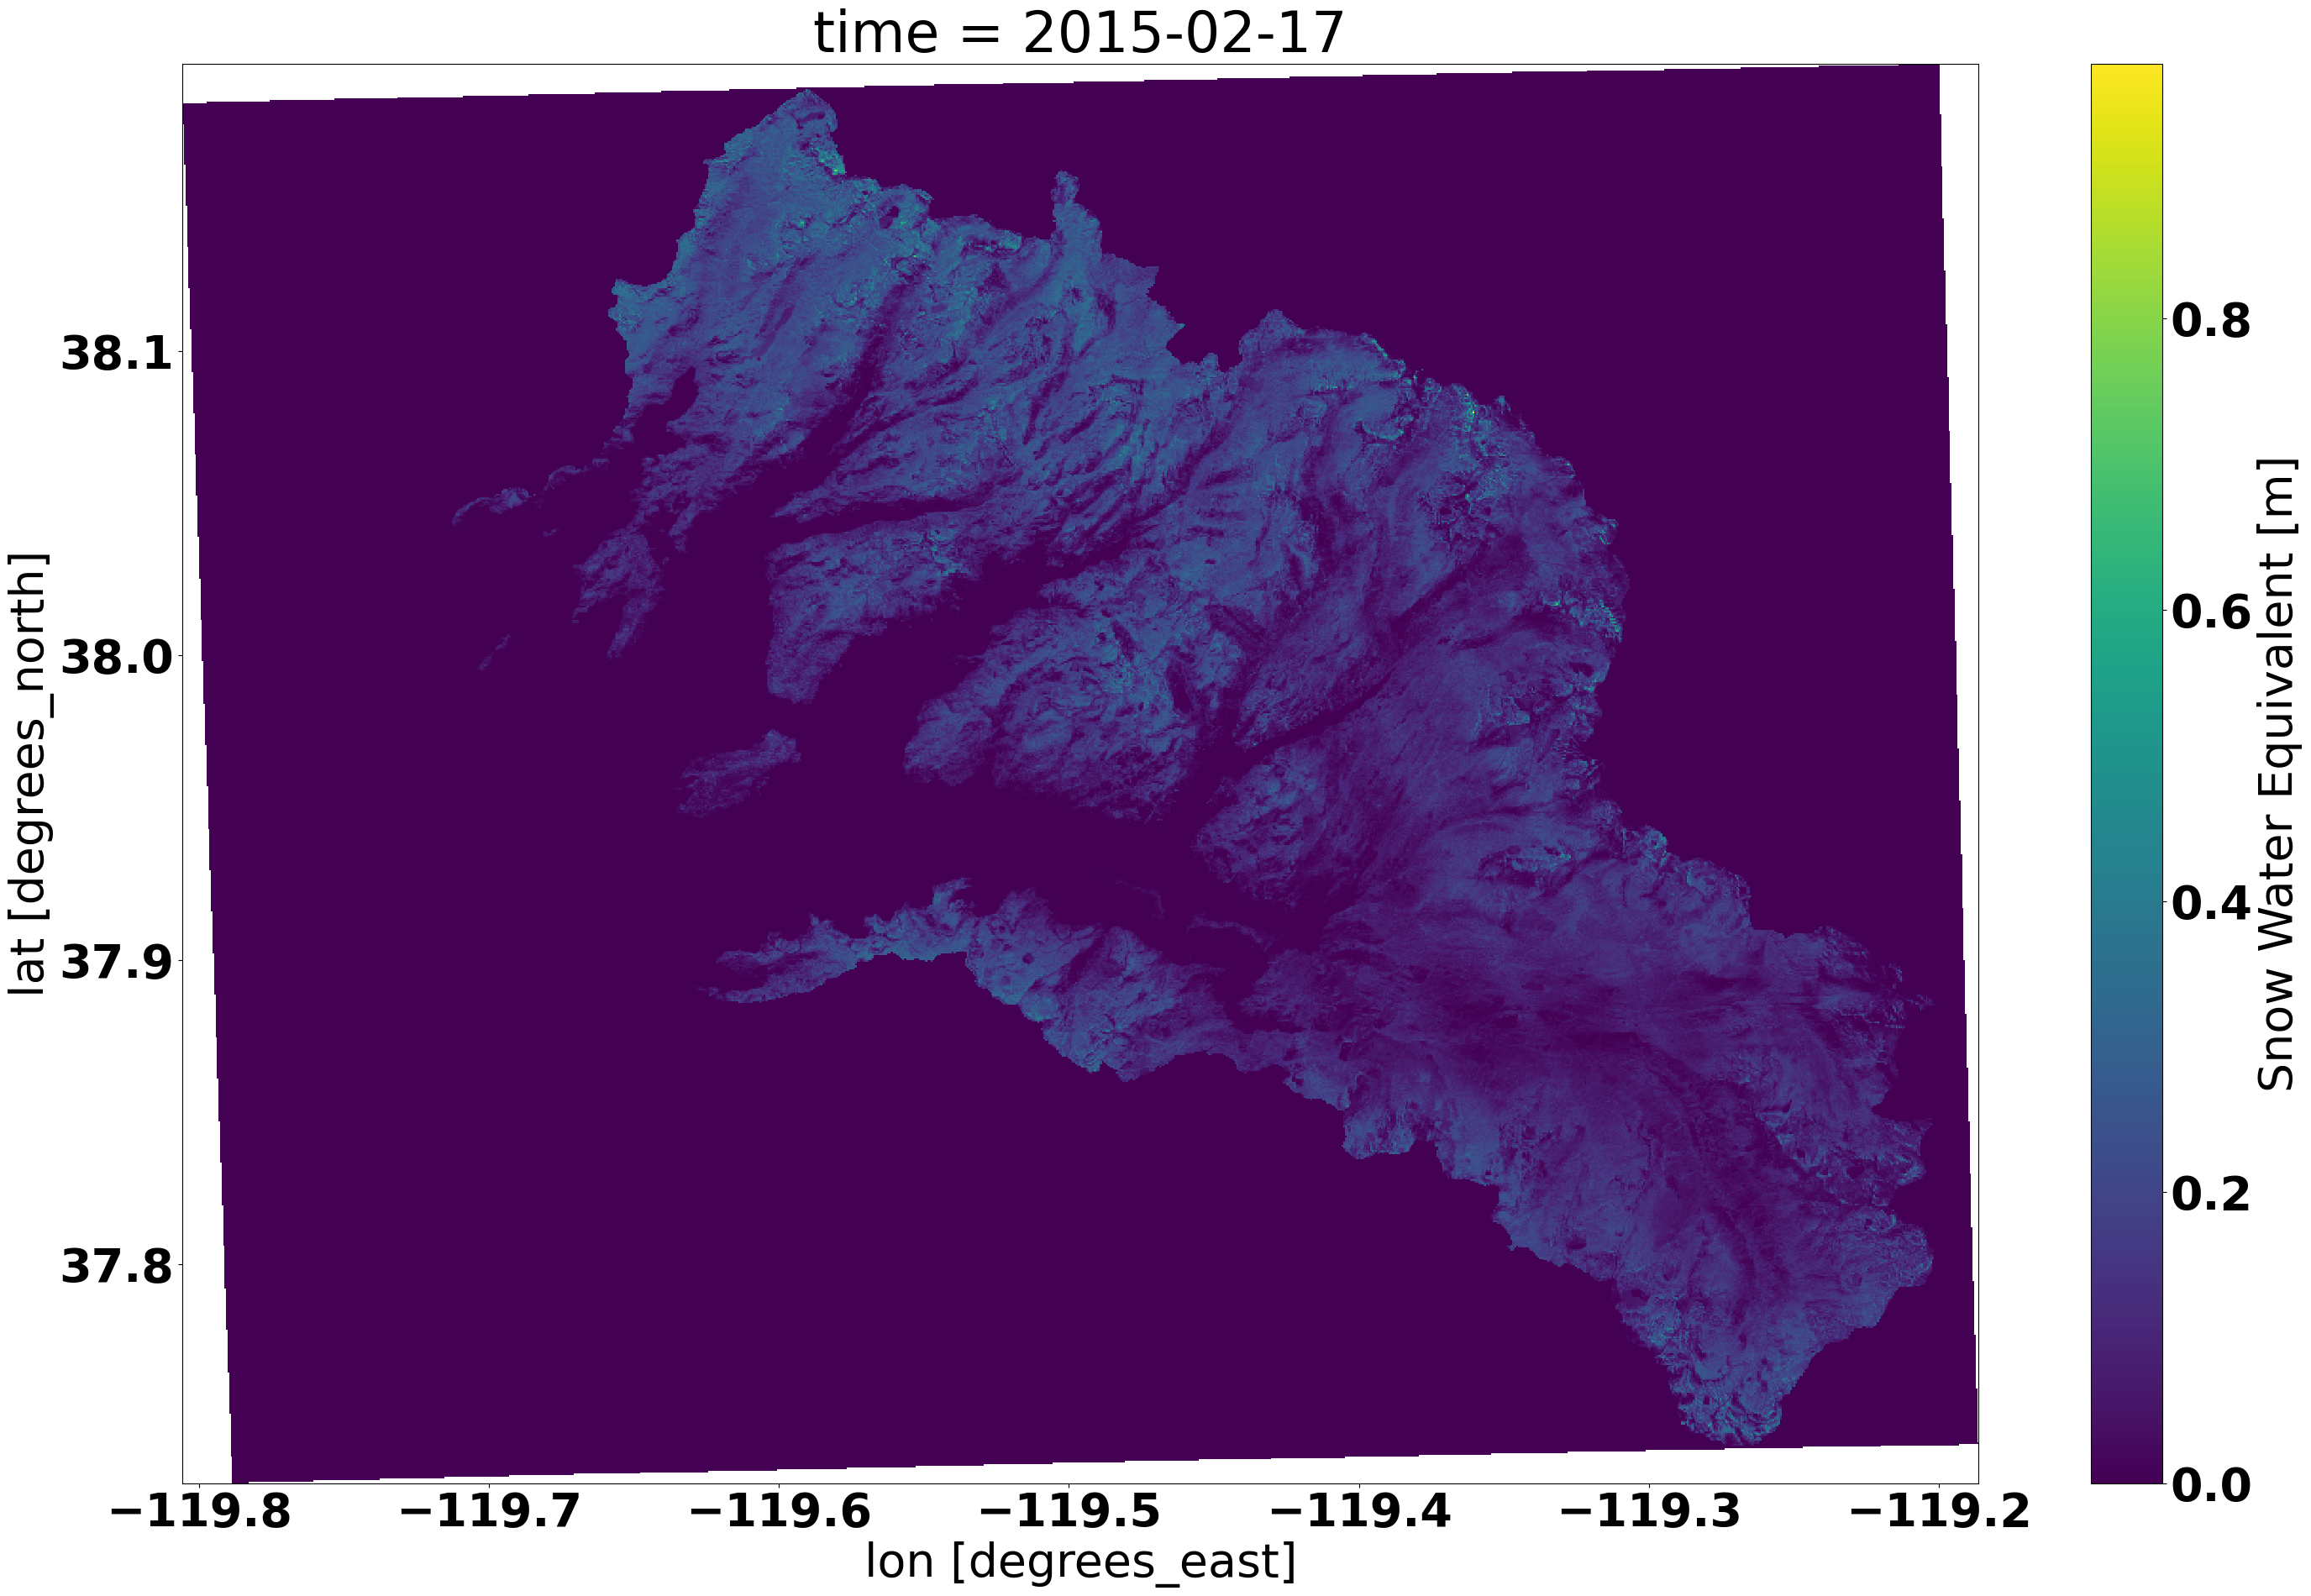

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

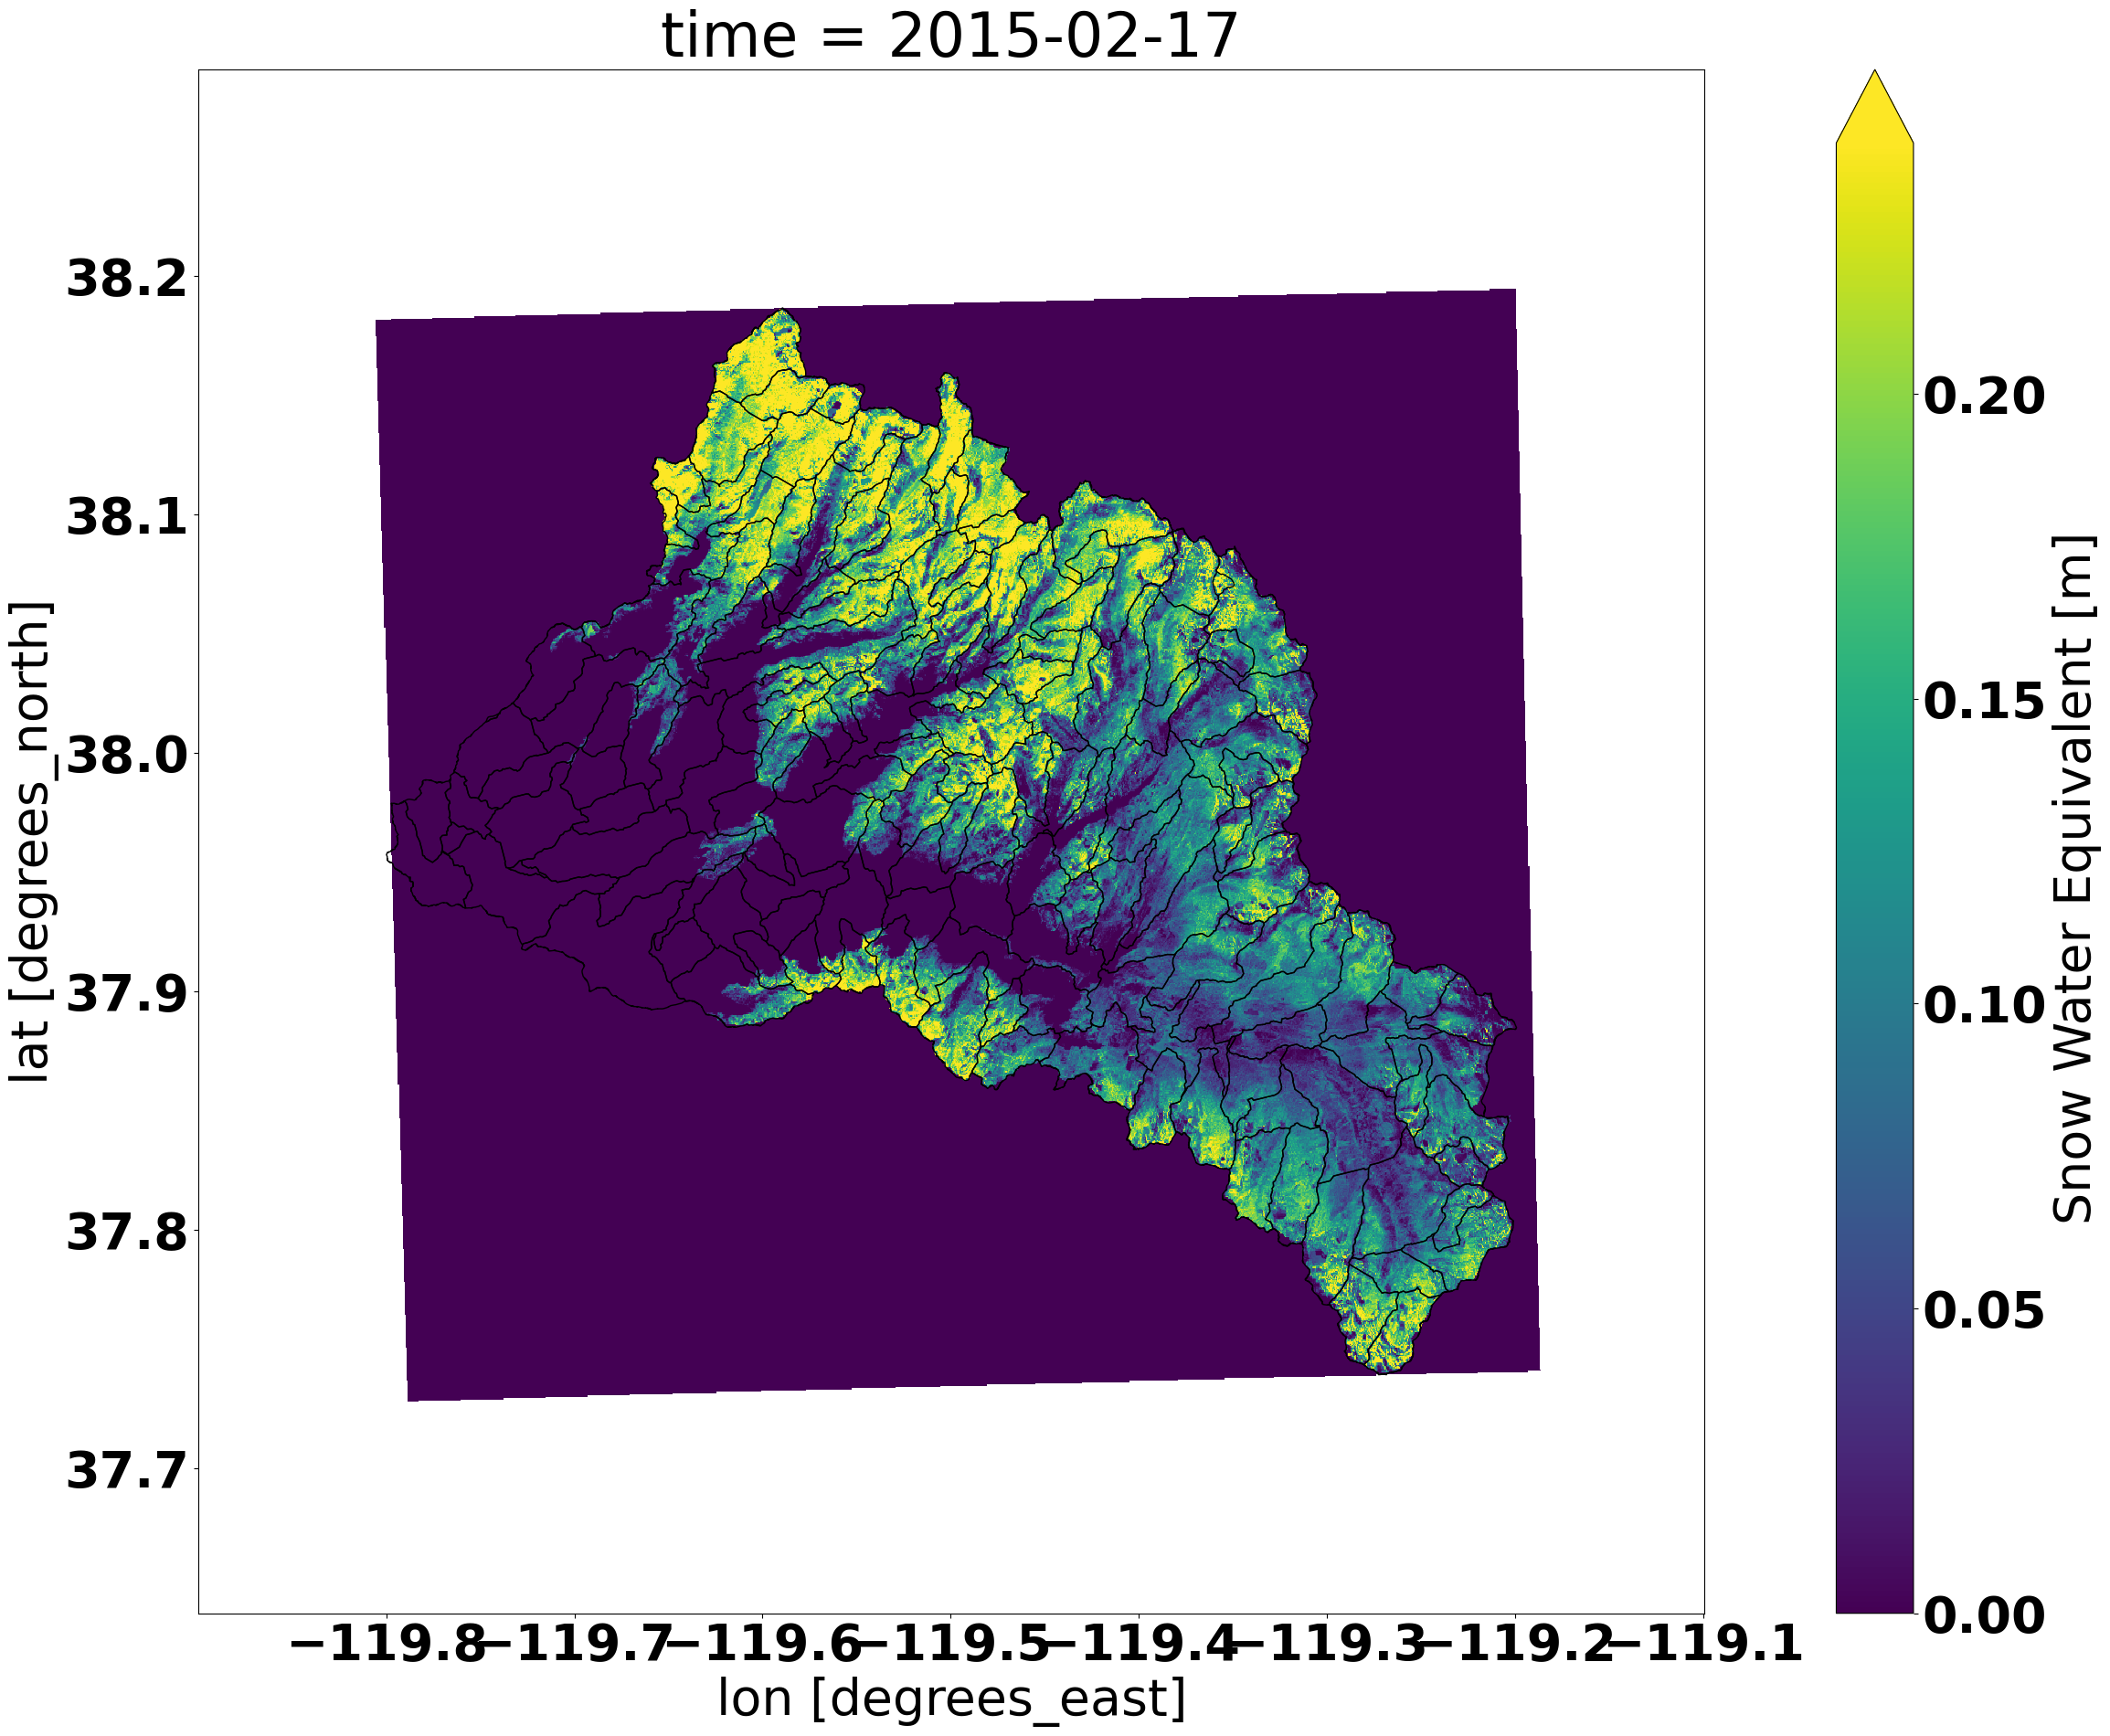

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

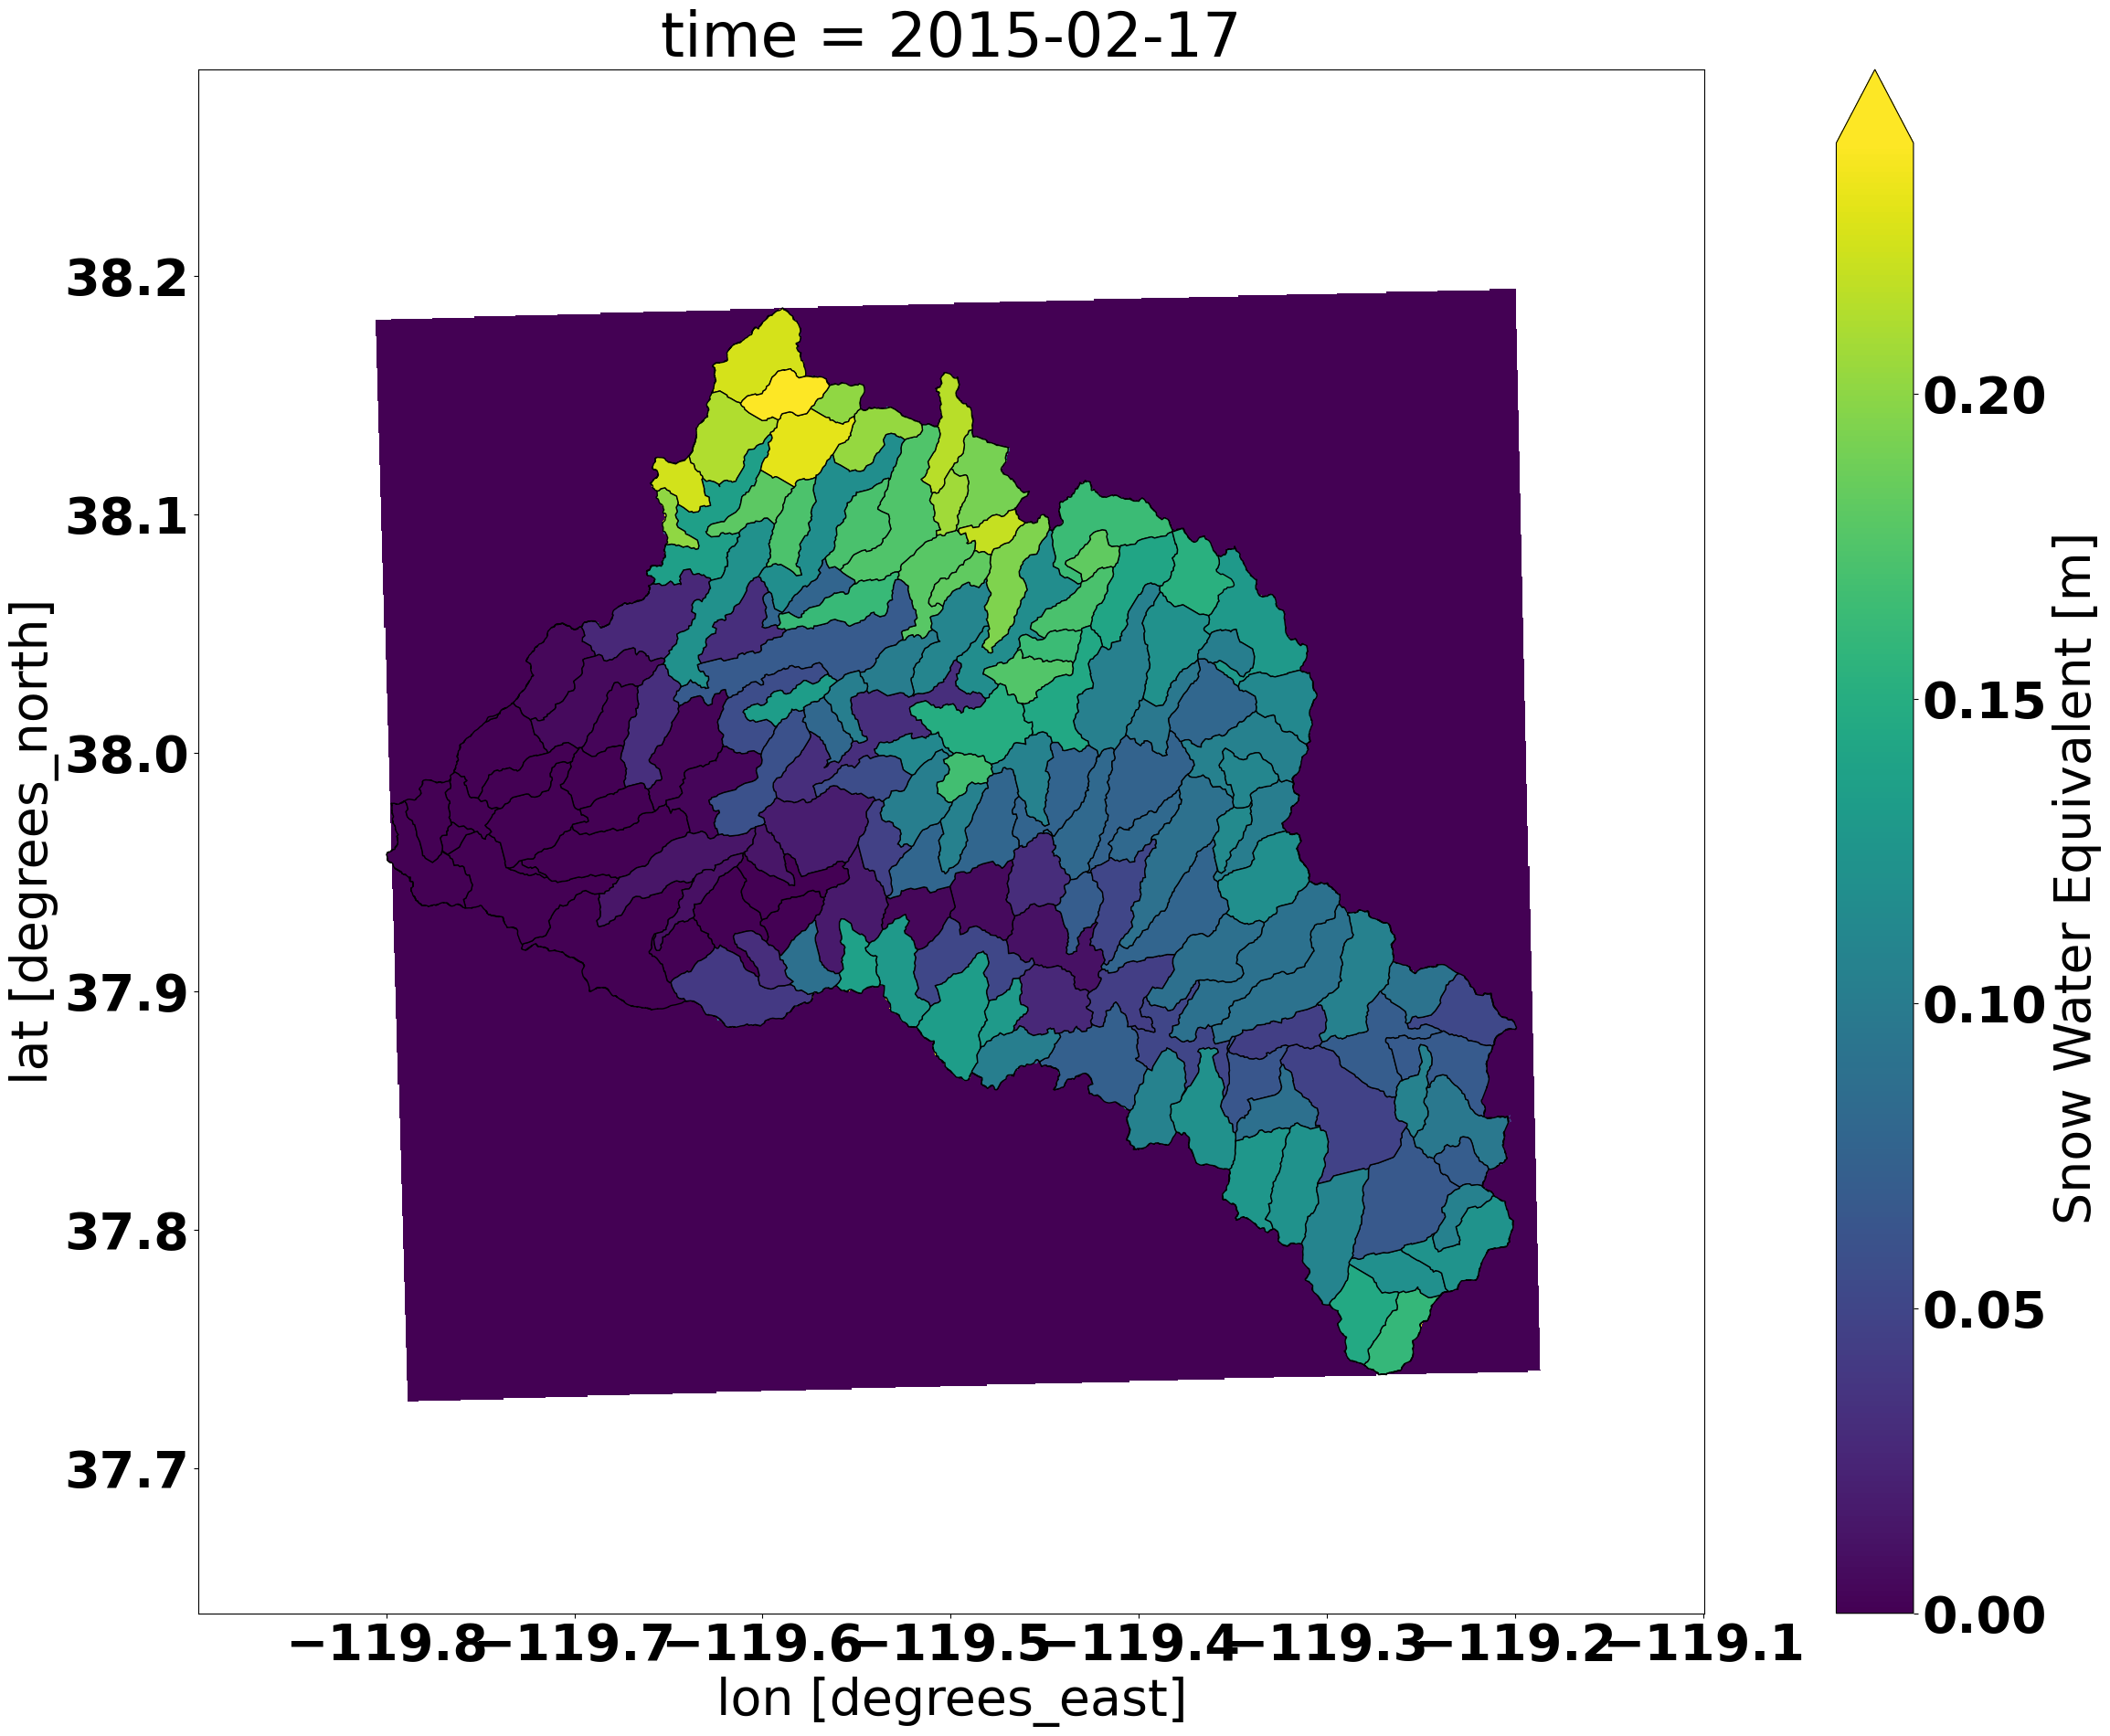

In [5]:
#Visualization of remapping


# loading EASYMORE
#from easymore import easymore # for version 1 and below
from easymore import Easymore # for version 2 and above

# initializing EASYMORE object
# esmr = easymore() # for version 1 and below
esmr = Easymore() # for version 2 and above

# define the source, and target files and parameters
case_name                  = 'USCATB_20150217_SWANN'  ###
source_nc_name             = 'proj/snow_proj/basins/ASO_basins/CA/reprojected/ASO_50M_SWE_USCATB_20150217_reproj.nc' ###
source_nc_var_lon          = 'lon'
source_nc_var_lat          = 'lat'
source_nc_var_time         = 'time'
source_nc_var_name         = 'SWE'
remapped_nc_name           = 'proj/snow_proj/basins/remapped_basins/USCATB_20150217_ASO_remapped_ASO_50M_SWE_USCATB_20150217_reproj.nc' ###
remapped_nc_var_name       = 'SWE'
remapped_nc_var_ID         = 'ID'
remapped_nc_var_time       = 'time'
time_step_of_viz           = '2015-02-17 00:00:00' ###
folder_save_fig            = 'scratch/data/remapped/'
target_shp_name            = 'proj/snow_proj/basins/hydrofabrics/USCATB_hydrofabric_reprojected.shp' ###
target_shp_field_ID        = 'id'
cmap                       = 'viridis'
linewidth_remapped         = 1
margin                     = 0.1
font_size                  = 40
fig_size                   = (30,20)

# the source nc file
esmr.nc_vis(source_nc_name             = source_nc_name,
            source_nc_var_lon          = source_nc_var_lon,
            source_nc_var_lat          = source_nc_var_lat,
            source_nc_var_time         = source_nc_var_time,
            source_nc_var_name         = source_nc_var_name,
            time_step_of_viz           = time_step_of_viz,
            location_save_fig          = folder_save_fig,
            fig_name                   = case_name+'_1.png',
            cmap                       = cmap,
            font_size                  = font_size,
            fig_size                   = fig_size)


# the source nc file zoom to target shapefile without showing the remapped variables
esmr.nc_vis(source_nc_name             = source_nc_name,
            source_nc_var_lon          = source_nc_var_lon,
            source_nc_var_lat          = source_nc_var_lat,
            source_nc_var_time         = source_nc_var_time,
            source_nc_var_name         = source_nc_var_name,
            remapped_nc_name           = remapped_nc_name,
            remapped_nc_var_name       = remapped_nc_var_name,
            remapped_nc_var_ID         = remapped_nc_var_ID,
            remapped_nc_var_time       = remapped_nc_var_time,
            time_step_of_viz           = time_step_of_viz,
            location_save_fig          = folder_save_fig,
            target_shp_name            = target_shp_name,
            linewidth_remapped         = linewidth_remapped,
            show_target_shp_flag       = True,
            fig_name                   = case_name+'_2.png',
            cmap                       = cmap,
            margin                     = margin,
            font_size                  = font_size,
            fig_size                   = fig_size)


# the source nc file zoom to target shapefile with showing the remapped variables
esmr.nc_vis(source_nc_name             = source_nc_name,
            source_nc_var_lon          = source_nc_var_lon,
            source_nc_var_lat          = source_nc_var_lat,
            source_nc_var_time         = source_nc_var_time,
            source_nc_var_name         = source_nc_var_name,
            remapped_nc_name           = remapped_nc_name,
            remapped_nc_var_name       = remapped_nc_var_name,
            remapped_nc_var_ID         = remapped_nc_var_ID,
            remapped_nc_var_time       = remapped_nc_var_time,
            time_step_of_viz           = time_step_of_viz,
            location_save_fig          = folder_save_fig,
            target_shp_name            = target_shp_name,
            target_shp_field_ID        = target_shp_field_ID,
            linewidth_remapped         = linewidth_remapped,
            show_target_shp_flag       = True,
            show_remapped_values_flag  = True,
            fig_name                   = case_name+'_3.png',
            cmap                       = cmap,
            margin                     = margin,
            font_size                  = font_size,
            fig_size                   = fig_size)



# merge the two figures into one
from PIL import Image, ImageFont, ImageDraw
image_list = [folder_save_fig+case_name+'_2.png' , folder_save_fig+case_name+'_3.png']
#image_list_cropped = [folder_save_fig+case_name+'_cropped_2.png' , folder_save_fig+case_name+'_cropped_3.png']

'''
# crop if needed, can be commneted
im = Image.open(image_list[0])
width, height = im.size      
crop_area = (0, 0, width*0.87, height) # (left, upper, right, lower)
cropped_image = im.crop(crop_area)
cropped_image.save(image_list_cropped[0])
#
im = Image.open(image_list[1])
width, height = im.size 
crop_area = (width*0.0622, 0, width, height) # (left, upper, right, lower)
cropped_image = im.crop(crop_area)
cropped_image.save(image_list_cropped[1])
'''
# merging
images = [Image.open(x) for x in image_list_cropped]
widths, heights = zip(*(i.size for i in images))
total_width = sum(widths)
max_height = max(heights)
new_im = Image.new('RGB', (total_width, max_height))
x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]
new_im.save(folder_save_fig+case_name+'.png')
new_im.save(folder_save_fig+'USCATB_20150217_ASO.png') ###
new_im.show()